In [2]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Reading in 1/4, 1/8, or 1/16 degree NW2 data:

In [4]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
#run=20; factor = (72/86400) #1/4 degree NeverWorld2 setup, factor is for the e^2 diagnostic which has an error associated with it.
#run=26; factor = (192/86400) #1/8 degree NeverWorld2 setup, factor is for the e^2 diagnostic which has an error associated with it.
run=28; factor = (540/86400) #1/16 degree NeverWorld2 setup,factor is for the e^2 diagnostic which has an error associated with it.
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
init=xr.open_dataset('run%i/MOM_IC.nc'% (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/
#print(fs)

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [256]:
## For reading in the 1/32 degree NW2 data:

In [3]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=33; factor = 1440/86400 #1/32 degree NeverWorld setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00002000.nc' % (run), decode_times=False)
init=xr.open_dataset('run33/MOM_IC.nc', decode_times=False)
av=xr.open_mfdataset(['run33/averages_00001502.nc','run33/averages_00001602.nc', 'run33/averages_00001702.nc', 'run33/averages_00001802.nc', 'run33/averages_00001902.nc'],decode_times=False,combine='by_coords')
# print(av)
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [5]:
#Read in various grid variables from the static file and forcing:
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']
depthmat = np.tile(depth,[100,15,1,1])
print(depthmat.shape)
area_t=fs['area_t']

xh = fs.xh.values
yh = fs.yh.values

interface_ref=os['H0'].values; interface_ref=interface_ref[-1,:-1]
interface_ref_mat=np.transpose(np.tile(interface_ref,[len(yh),len(xh),100,1]),[2,3,0,1])
print(interface_ref_mat.shape)


Layer = np.array(os['Layer']);
drho=np.zeros(15);
drho[0]=Layer[0]; drho[1:]=np.diff(Layer)
print(drho); #drho contains the density differences across each interface. 15 entries, includes surface but not bottom.
drhomat=np.transpose(np.tile(drho,[len(yh),len(xh),1]),[2,0,1])

(100, 15, 2240, 960)
(100, 15, 2240, 960)
[1.0226e+03 2.1000e-01 3.9000e-01 5.4000e-01 5.8000e-01 5.8000e-01
 5.7000e-01 5.3000e-01 4.8000e-01 4.2000e-01 3.7000e-01 3.1000e-01
 2.4000e-01 1.7000e-01 1.1000e-01]


In [6]:
interface_ref_mat.shape

(100, 15, 2240, 960)

In [7]:
h = np.array(av['h'][:,:,:,:]); h[np.isnan(h)]=0.0
correction  = (interface_ref_mat-depthmat); #if >0 this means h_ref is deeper than topography, we need correction!
correction[correction<0]=0.0 #if correction <0 that means depth is larger than h_ref, we don't need correction!
e2 = np.array(av['e2'][:,:-1,:,:])*factor; e2[np.isnan(e2)]=0.0

interface = np.zeros(h.shape);
for t in range (0,100):
    for i in range(0,len(Layer)):
        interface[t,i,:,:]=-((np.nansum(h[t,i:,:,:],axis=0))-depthmat[t,i,:,:])
    print(t)
#eta2_term_average=(interface-interface_ref_mat)**2-correction**2
eta2_correct= (e2-depthmat**2+2*depthmat*(depthmat-interface))-2*(depthmat-interface)*(depthmat-interface_ref_mat)+(depthmat-interface_ref_mat)**2-correction**2
print('done')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
done


In [43]:
drhomat.shape

(15, 560, 240)

In [55]:
depthmat.shape

(100, 15, 560, 240)

In [1]:
#APE_full_average=np.zeros(eta2_term_average[0,:,:,:].shape); 
APE_full_correct=np.zeros(eta2_correct[0,:,:,:].shape); 

eta2_mean = np.nanmean(eta2_correct[:,:,:,:],axis=0);
for i in range(0,len(interface_ref_mat[0,0,:,0])): #looping over x
    for j in range(0,len(interface_ref_mat[0,0,0,:])): #looping over y
#        APE_full_average[:,i,j] = 0.5*9.81*drhomat[:,i,j]*np.nanmean(eta2_term_average[:,:,i,j],axis=0)/(1025*depthmat[0,:,i,j])#+9.81*drhomat[:,i,j]*h[:,i,j]*eta_5day_average[:,i,j]/(1025*depth_3D[:,i,j])
        APE_full_correct[:,i,j] = 0.5*9.81*drhomat[:,i,j]*(eta2_mean[:,i,j])/(1025*depthmat[0,:,i,j])
    #print(i)
    
#APE_5day   =np.nansum(APE_full_average,axis=0)
APE_correct=np.nansum(APE_full_correct,axis=0)

print('done')    

NameError: name 'np' is not defined

In [282]:
#np.nansum(APE_5day*area_t)

In [283]:
#np.nansum(APE_correct*area_t)

In [19]:
#APE_025=APE_5day
APE_003125_correct=APE_correct
yh_003125=yh
print('done')

done


Text(0.5, 1.0, 'Zonally averaged APE')

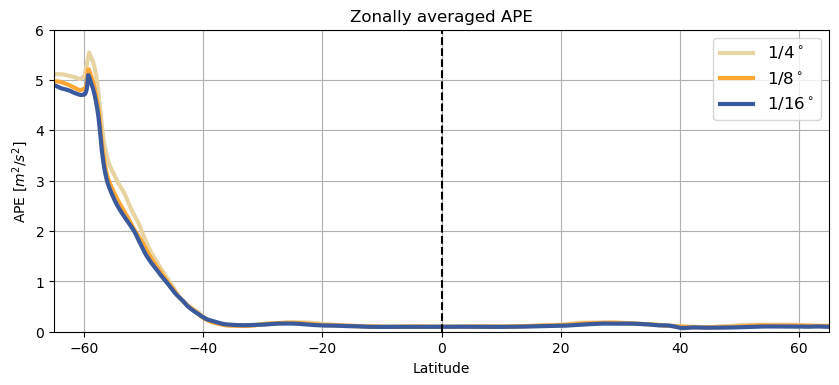

In [26]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_025,np.nanmean(APE_025_correct,axis=1),'-',c='#e8d3a3',linewidth=3)
plt.plot(yh_0125,np.nanmean(APE_0125_correct,axis=1),'-',c='#ffa633',linewidth=3)
plt.plot(yh_00625,np.nanmean(APE_00625_correct,axis=1),'-',c='#3b5a9d',linewidth=3)
#plt.plot(yh_003125,np.nanmean(APE_003125_correct,axis=1),'-',c='#4fb2aa',linewidth=3)


plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

plt.legend(['1/4$^\circ$','1/8$^\circ$','1/16$^\circ$'],loc='upper right',fontsize=12)
#plt.legend(['KE_tot 1/4 $^\circ$','KE_tot_ref 1/4$^\circ$','KE_tot 1/16 $^\circ$','KE_tot_ref 1/16$^\circ$'],loc='upper right',fontsize=8)
plt.plot([0, 0],[0, 10],'--',color=[0,0,0])
plt.xlim(-65,65)

plt.ylim(0,6);
plt.xlabel('Latitude')
plt.ylabel('APE [$m^2/s^2$]')
plt.title('Zonally averaged APE')

In [23]:
from scipy import interpolate

APE_025   = np.nanmean(APE_025_correct,axis=1)
APE_0125  = np.nanmean(APE_0125_correct,axis=1)
APE_00625 = np.nanmean(APE_00625_correct,axis=1)
#APE_003125= np.nanmean(APE_003125_correct,axis=1)

f1 = interpolate.interp1d(yh_0125, APE_0125)
f2 = interpolate.interp1d(yh_00625, APE_00625)
#f3 = interpolate.interp1d(yh_003125, APE_003125)

APE_0125interp   = f1(yh_025)
APE_00625interp  = f2(yh_025)
#APE_003125interp = f3(yh_025)

frac_025    =APE_025/APE_025
frac_0125   =APE_0125interp/APE_025
frac_00625  =APE_00625interp/APE_025
#frac_003125 =APE_003125interp/APE_025
print('done')

done


Text(0.5, 1.0, 'APE relative to 1/4 degree simulation')

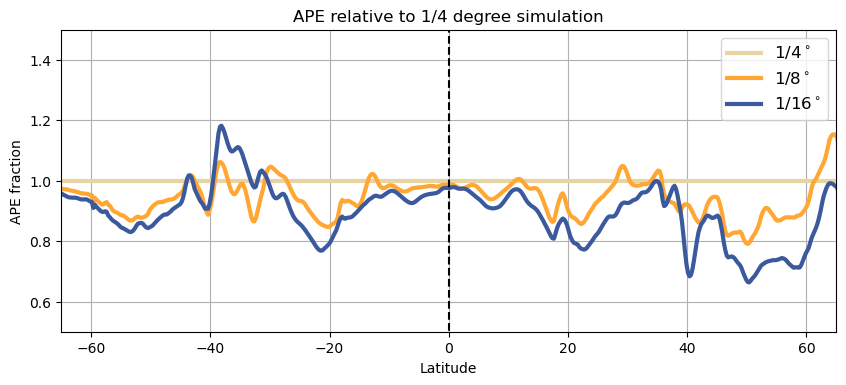

In [27]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_025,frac_025,'-',c='#e8d3a3',linewidth=3)
plt.plot(yh_025,frac_0125,'-',c='#ffa633',linewidth=3)
plt.plot(yh_025,frac_00625,'-',c='#3b5a9d',linewidth=3)
#plt.plot(yh_025,frac_003125,'-',c='#4fb2aa',linewidth=3)


plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

plt.legend(['1/4$^\circ$','1/8$^\circ$','1/16$^\circ$'],loc='upper right',fontsize=12)
#plt.legend(['KE_tot 1/4 $^\circ$','KE_tot_ref 1/4$^\circ$','KE_tot 1/16 $^\circ$','KE_tot_ref 1/16$^\circ$'],loc='upper right',fontsize=8)
plt.plot([0, 0],[0, 10],'--',color=[0,0,0])
plt.xlim(-65,65)

plt.ylim(0.5,1.5);
plt.xlabel('Latitude')
plt.ylabel('APE fraction')
plt.title('APE relative to 1/4 degree simulation')

In [113]:
2.25e17

2.25e+17